In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

In [2]:
WHITE = np.array([255, 255, 255], dtype=np.uint8)
BLACK = np.array([0, 0, 0], dtype=np.uint8)

path_maze = './mazes/3030.png'

In [3]:
image_maze = cv.imread(path_maze)

In [4]:
class MazeGraph:
    
    def __init__(self, image_maze):
        
        self.image = image_maze
        
        enter_start, enter_end = self.__identify_gap_h(0)
        exit_start, exit_end = self.__identify_gap_h(self.image.shape[0] - 1)
        wall_start, wall_end = self.__identify_gap_v(enter_start)

        self.cell_width = enter_end - enter_start
        wall_width = wall_end - wall_start
        
        self.step = self.cell_width + wall_width

        shape = (self.image.shape[0] // self.step, 
                 self.image.shape[1] // self.step)

        self.cells_visited = np.zeros(shape=shape, dtype=np.uint32)

        self.start_v, self.start_h = wall_width, enter_start
        self.stop = np.array([self.image.shape[0] - self.step, exit_start],
                             dtype=np.uint32)
        
        self.queue = []
        self.route = []

    def __get_adj(self, i, j):
        
        adj = []
        
        if np.all(self.image[i + self.cell_width, j] == WHITE) and i + self.step < self.image.shape[0]:
            adj.append(np.array([i + self.step, j], dtype=np.uint32))
            
        if np.all(self.image[i, j + self.cell_width] == WHITE) and j + self.step < self.image.shape[1]:
            adj.append(np.array([i, j + self.step], dtype=np.uint32))
            
        if np.all(self.image[i - 1, j] == WHITE) and i - self.step > 0:
            adj.append(np.array([i - self.step, j], dtype=np.uint32))
            
        if np.all(self.image[i, j - 1] == WHITE) and j - self.step > 0:
            adj.append(np.array([i, j - self.step], dtype=np.uint32))
            
        return adj
    
    def __forward_pass(self):
        
        self.cells_visited[self.start_v // self.step, self.start_h // self.step] = 1
        
        self.queue.append(np.array([self.start_v, self.start_h], dtype=np.uint32))
        
        cell_curr = None
        
        is_exit_found = False
        
        while len(self.queue) and not is_exit_found:
            
            cell_curr = self.queue.pop(0)
            adjs = self.__get_adj(cell_curr[0], cell_curr[1])
            
            for adj in adjs:
                
                i_curr, j_curr = cell_curr // self.step 
                i, j = adj // self.step
                
                if self.cells_visited[i, j] == 0:
                
                    self.cells_visited[i, j] = self.cells_visited[i_curr, j_curr] + 1

                    if np.all(adj == self.stop):

                        is_exit_found = True
                        break

                    self.queue.append(adj)
        
    def __backward_pass(self):
        
        i, j = self.stop // self.step
        
        dist_curr = self.cells_visited[i, j]
        cell_curr = self.stop
        
        self.route.append(self.stop)
        
        while dist_curr != 1:
            
            adjs = self.__get_adj(cell_curr[0], cell_curr[1])
            
            for adj in adjs:
                
                i, j = adj // self.step
                
                if self.cells_visited[i, j] == dist_curr - 1:
                    
                    cell_curr = adj
                    dist_curr -= 1
                    
                    break

            self.route.append(cell_curr)
                
    def __identify_gap_h(self, row):
        
        color_prev = self.image[row, 0]
        gap_start, gap_end = None, None

        for i in range(1, self.image.shape[1]):

            if np.all(self.image[row, i] != color_prev):
                color_prev = self.image[row, i]
                gap_start = i
                break

        for i in range(gap_start, self.image.shape[1]):

            if np.all(self.image[row, i] != color_prev):
                gap_end = i
                break

        return gap_start, gap_end
    
    def __identify_gap_v(self, column):
        
        color_prev = self.image[0, column]
        gap_start, gap_end = None, None

        for i in range(1, self.image.shape[0]):

            if np.all(self.image[i, column] != color_prev):
                color_prev = self.image[i, column]
                gap_start = i
                break

        for i in range(gap_start, self.image.shape[0]):

            if np.all(self.image[i, column] != color_prev):
                gap_end = i
                break

        return gap_start, gap_end
    
    def get_route(self):
        
        self.__forward_pass()
        self.__backward_pass()
        
        self.route.reverse()
        
        route = np.array(self.route)
        route += self.cell_width // 2
        
        exit = np.array([self.image.shape[0], route[-1, 1]], dtype=np.uint32)
        enter = np.array([0, route[0, 1]], dtype=np.uint32)
        
        route = np.vstack((enter, route, exit))
        
        self.route = []
        
        return route

In [5]:
mg = MazeGraph(image_maze)

In [6]:
%%time

arr = mg.get_route()

CPU times: total: 62.5 ms
Wall time: 57 ms


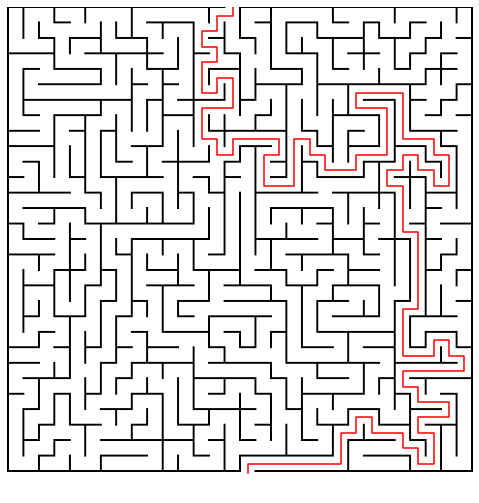

In [7]:
plt.figure(figsize=(9, 9))
plt.imshow(image_maze)
plt.axis('off')
plt.plot(arr[:, 1], arr[:, 0], c='r');